In [1]:
%pip install -q transformers datasets scikit-learn pandas numpy matplotlib seaborn tqdm
%pip install -q torchaudio torch torchvision --index-url https://download.pytorch.org/whl/cu126

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import time
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


d:\CODE\CCS\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [2]:
# Define the path to your data
data_path = './data/complaints.csv'  # Adjust this path as needed

# Load the data
df = pd.read_csv(data_path)

# Display basic information
print("Dataset shape:", df.shape)
print("\nColumn names:", df.columns.tolist())
print("\nFirst few rows:")
df.head()

Dataset shape: (11454886, 18)

Column names: ['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative', 'Company public response', 'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?', 'Submitted via', 'Date sent to company', 'Company response to consumer', 'Timely response?', 'Consumer disputed?', 'Complaint ID']

First few rows:


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2020-07-06,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,FL,346XX,NaN,Other,Web,2020-07-06,Closed with explanation,Yes,NaN,3730948
1,2025-10-14,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information is missing that should be on the r...,NaN,NaN,"EQUIFAX, INC.",TX,75062,NaN,NaN,Web,2025-10-14,In progress,Yes,NaN,16558024
2,2025-10-10,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"EQUIFAX, INC.",GA,30341,NaN,NaN,Web,2025-10-10,In progress,Yes,NaN,16507707
3,2025-09-30,Mortgage,Conventional home mortgage,Trouble during payment process,"Escrow, taxes, or insurance",NaN,NaN,Ocwen Financial Corporation,TN,37411,NaN,NaN,Web,2025-09-30,In progress,Yes,NaN,16278077
4,2025-09-30,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"EQUIFAX, INC.",TX,77864,NaN,NaN,Web,2025-09-30,In progress,Yes,NaN,16261175


Missing values per column:
Date received                          0
Product                                0
Sub-product                       235295
Issue                                  6
Sub-issue                         860916
Consumer complaint narrative     8050112
Company public response          5684215
Company                                0
State                              56756
ZIP code                           30229
Tags                            10784214
Consumer consent provided?       1917377
Submitted via                          0
Date sent to company                   0
Company response to consumer          20
Timely response?                       0
Consumer disputed?              10686602
Complaint ID                           0
dtype: int64


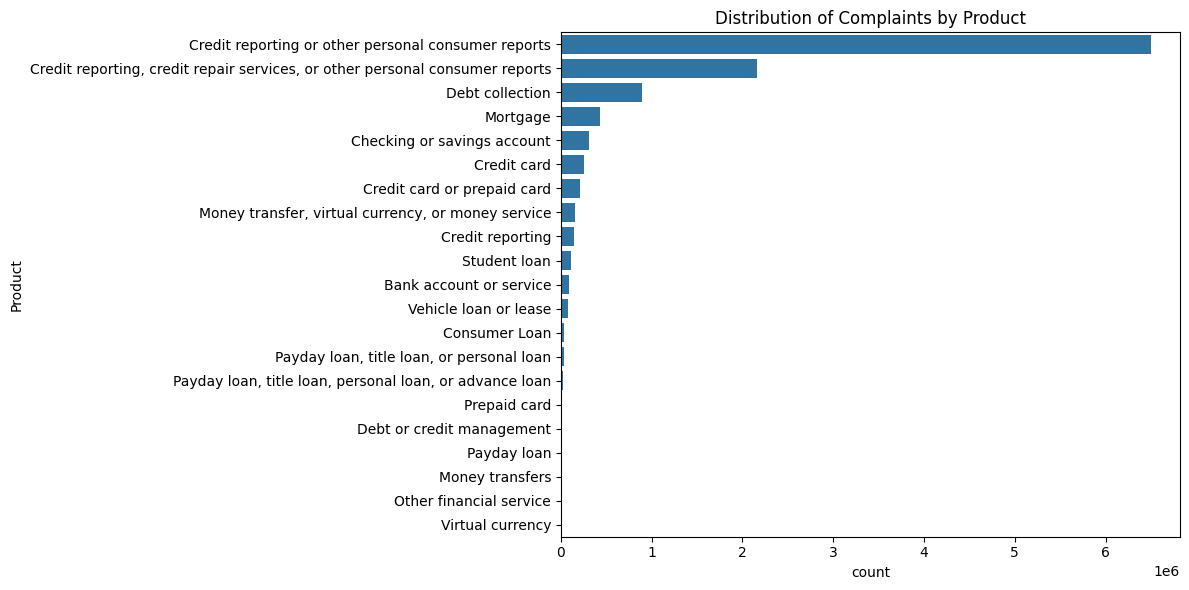

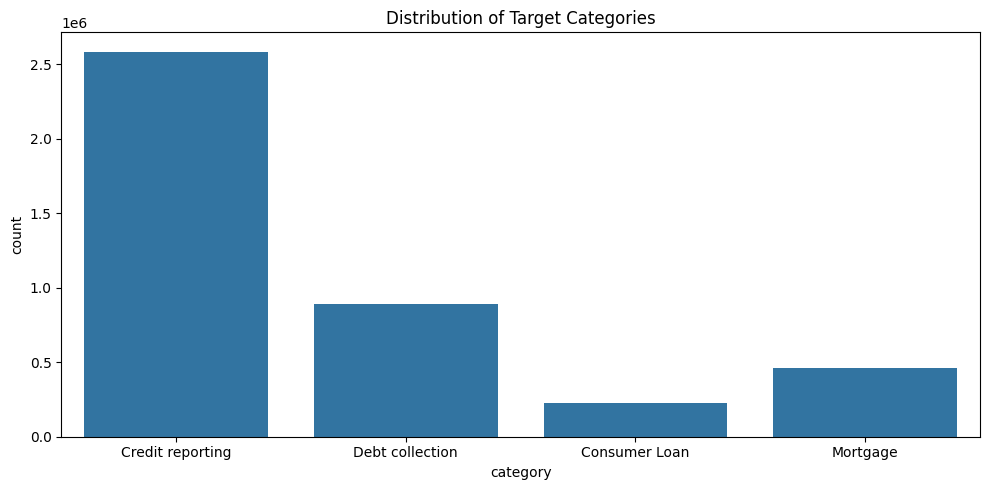

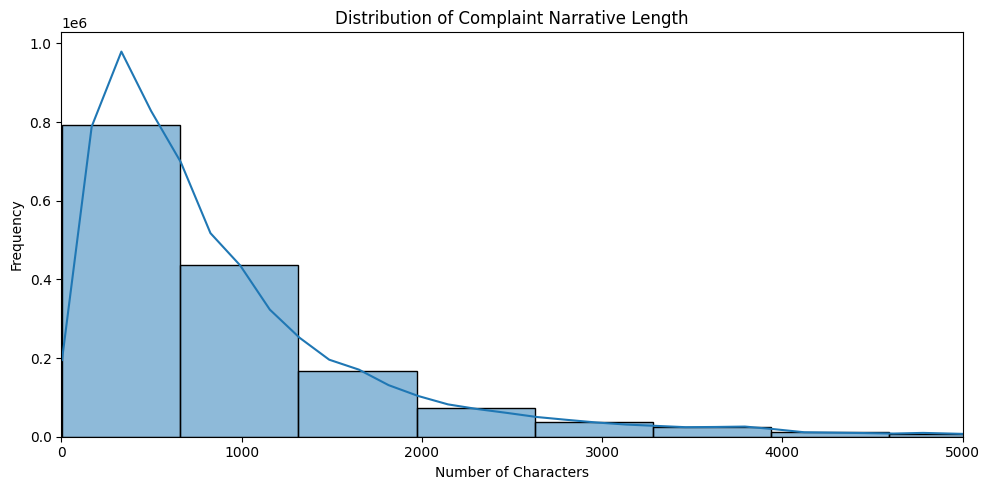

In [3]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Distribution of complaints by product
plt.figure(figsize=(12, 6))
sns.countplot(y='Product', data=df, order=df['Product'].value_counts().index)
plt.title('Distribution of Complaints by Product')
plt.tight_layout()
plt.show()

# Map products to our target categories
product_to_category = {
    'Credit reporting, credit repair services, or other personal consumer reports': 0,
    'Credit reporting': 0,
    'Credit card': 0,
    'Prepaid card': 0,
    'Payday loan': 0,
    'Money transfer': 0,
    'Virtual currency': 0,

    'Debt collection': 1,

    'Consumer Loan': 2,
    'Vehicle loan or lease': 2,
    'Student loan': 2,

    'Mortgage': 3,
    'Payday loan, title loan, or personal loan': 3
}

# Create the target column
df['category'] = df['Product'].map(product_to_category)

# Filter out rows with no category
df = df.dropna(subset=['category'])
df['category'] = df['category'].astype(int)

# Check distribution of our target categories
plt.figure(figsize=(10, 5))
sns.countplot(x='category', data=df)
plt.title('Distribution of Target Categories')
plt.xticks([0, 1, 2, 3],
           ['Credit reporting', 'Debt collection', 'Consumer Loan', 'Mortgage'])
plt.tight_layout()
plt.show()

# Check the length of complaint narratives
df['text_length'] = df['Consumer complaint narrative'].str.len()
plt.figure(figsize=(10, 5))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title('Distribution of Complaint Narrative Length')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.xlim(0, 5000)  # Limit x-axis for better visualization
plt.tight_layout()
plt.show()

In [4]:
def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

tqdm.pandas()
df['processed_text'] = df['Consumer complaint narrative'].progress_apply(preprocess_text)

# Drop rows with empty processed text
df = df[df['processed_text'] != '']
print(f"Dataset shape after preprocessing: {df.shape}")

# Split the data
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['category']
)

print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")

100%|██████████| 4163448/4163448 [01:35<00:00, 43778.42it/s] 


Dataset shape after preprocessing: (1575605, 21)
Training set size: 1260484
Test set size: 315121


In [ ]:
# Create a simple TF-IDF + Logistic Regression model as our lightweight baseline
def create_lightweight_model():
    # Create TF-IDF features
    vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

    # Fit on training data
    X_train = vectorizer.fit_transform(train_df['processed_text'])
    X_test = vectorizer.transform(test_df['processed_text'])

    y_train = train_df['category']
    y_test = test_df['category']

    # Train a logistic regression model
    model = LogisticRegression(max_iter=1000, n_jobs=-1)

    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Make predictions
    start_time = time.time()
    y_pred = model.predict(X_test)
    prediction_time = time.time() - start_time

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Print results
    print(f"Lightweight Model (TF-IDF + Logistic Regression)")
    print(f"Training time: {training_time:.2f} seconds")
    print(f"Prediction time: {prediction_time:.2f} seconds")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Mean Squared Error: {mse:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Credit', 'Debt', 'Loan', 'Mortgage'],
                yticklabels=['Credit', 'Debt', 'Loan', 'Mortgage'])
    plt.title('Confusion Matrix - Lightweight Model')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred,
                               target_names=['Credit', 'Debt', 'Loan', 'Mortgage']))

    return {
        'model': model,
        'vectorizer': vectorizer,
        'accuracy': accuracy,
        'mse': mse,
        'confusion_matrix': cm,
        'training_time': training_time,
        'prediction_time': prediction_time
    }

# Run the lightweight model
lightweight_results = create_lightweight_model()

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
import time
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from torch.cuda.amp import autocast, GradScaler

# Define a PyTorch Dataset for our text data
class ComplaintDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):  # Reduced max_length
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = self.labels.iloc[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Function to train and evaluate a transformer model with optimizations
def train_transformer_model(model_name, use_fast_model=True):
    print(f"\nTraining {model_name} model...")
    
    # Check if GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Use a faster model variant if available
    if use_fast_model and model_name == 'distilbert-base-uncased':
        model_name = 'distilbert-base-uncased-finetuned-sst-2-english'  # Already fine-tuned, faster convergence
    
    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)  # Use fast tokenizer
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=4  # We have 4 categories
    ).to(device)

    # Create datasets
    train_dataset = ComplaintDataset(
        train_df['processed_text'],
        train_df['category'],
        tokenizer,
        max_length=256  # Reduced from 512
    )
    test_dataset = ComplaintDataset(
        test_df['processed_text'],
        test_df['category'],
        tokenizer,
        max_length=256  # Reduced from 512
    )

    # Define training arguments with optimizations
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=2,  # Reduced from 3
        per_device_train_batch_size=32,  # Increased from 16
        per_device_eval_batch_size=32,  # Increased from 16
        warmup_steps=100,  # Reduced from 500
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=50,  # Reduced from 100
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        greater_is_better=True,
        report_to="none",  # Disable wandb/tensorboard reporting
        fp16=True,  # Enable mixed precision training
        dataloader_num_workers=4,  # Use multiple workers for data loading
        gradient_accumulation_steps=1,  # Can increase if memory is an issue
        learning_rate=5e-5,  # Slightly higher learning rate for faster convergence
    )

    # Define metrics computation function
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        accuracy = accuracy_score(labels, predictions)
        mse = mean_squared_error(labels, predictions)
        return {
            'accuracy': accuracy,
            'mse': mse
        }

    # Create Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics
    )

    # Train the model
    start_time = time.time()
    trainer.train()
    training_time = time.time() - start_time

    # Evaluate the model
    start_time = time.time()
    predictions = trainer.predict(test_dataset)
    prediction_time = time.time() - start_time

    # Get predicted labels
    y_pred = np.argmax(predictions.predictions, axis=1)
    y_true = test_df['category'].values

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    # Print results
    print(f"{model_name} Model")
    print(f"Training time: {training_time:.2f} seconds")
    print(f"Prediction time: {prediction_time:.2f} seconds")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Mean Squared Error: {mse:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Credit', 'Debt', 'Loan', 'Mortgage'],
                yticklabels=['Credit', 'Debt', 'Loan', 'Mortgage'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred,
                               target_names=['Credit', 'Debt', 'Loan', 'Mortgage']))

    return {
        'model': model,
        'tokenizer': tokenizer,
        'accuracy': accuracy,
        'mse': mse,
        'confusion_matrix': cm,
        'training_time': training_time,
        'prediction_time': prediction_time
    }

# Option 1: Train a lightweight transformer model with optimizations
distilbert_results = train_transformer_model('distilbert-base-uncased')

# Option 2: Try an even faster model
# tinybert_results = train_transformer_model('huawei-noah/TinyBERT_General_4L_312D')



Training distilbert-base-uncased model...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


: 

: 

In [ ]:
# Create a comparison table
models = {
    'TF-IDF + Logistic Regression': lightweight_results,
    'DistilBERT': distilbert_results
}

comparison_df = pd.DataFrame({
    'Model': list(models.keys()),
    'Accuracy': [m['accuracy'] for m in models.values()],
    'MSE': [m['mse'] for m in models.values()],
    'Training Time (s)': [m['training_time'] for m in models.values()],
    'Prediction Time (s)': [m['prediction_time'] for m in models.values()]
})

# Display the comparison table
print("Model Performance Comparison:")
display(comparison_df)

# Visualize the comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy comparison
sns.barplot(x='Model', y='Accuracy', data=comparison_df, ax=axes[0, 0])
axes[0, 0].set_title('Model Accuracy Comparison')
axes[0, 0].set_ylim(0, 1)
for i, acc in enumerate(comparison_df['Accuracy']):
    axes[0, 0].text(i, acc + 0.01, f'{acc:.4f}', ha='center')

# MSE comparison
sns.barplot(x='Model', y='MSE', data=comparison_df, ax=axes[0, 1])
axes[0, 1].set_title('Model MSE Comparison')
for i, mse in enumerate(comparison_df['MSE']):
    axes[0, 1].text(i, mse + 0.01, f'{mse:.4f}', ha='center')

# Training time comparison
sns.barplot(x='Model', y='Training Time (s)', data=comparison_df, ax=axes[1, 0])
axes[1, 0].set_title('Model Training Time Comparison')
for i, t in enumerate(comparison_df['Training Time (s)']):
    axes[1, 0].text(i, t + 5, f'{t:.2f}s', ha='center')

# Prediction time comparison
sns.barplot(x='Model', y='Prediction Time (s)', data=comparison_df, ax=axes[1, 1])
axes[1, 1].set_title('Model Prediction Time Comparison')
for i, t in enumerate(comparison_df['Prediction Time (s)']):
    axes[1, 1].text(i, t + 0.5, f'{t:.2f}s', ha='center')

plt.tight_layout()
plt.show()

In [ ]:
# Select the best model based on accuracy
best_model_name = comparison_df.loc[comparison_df['Accuracy'].idxmax(), 'Model']
print(f"Best performing model: {best_model_name}")

# Function to make predictions on new data
def predict_complaint(text, model_name):
    # Preprocess the text
    processed_text = preprocess_text(text)

    if model_name == 'TF-IDF + Logistic Regression':
        # Use the lightweight model
        vectorized_text = lightweight_results['vectorizer'].transform([processed_text])
        prediction = lightweight_results['model'].predict(vectorized_text)[0]
        probabilities = lightweight_results['model'].predict_proba(vectorized_text)[0]
    else:
        # Use the transformer model
        encoding = distilbert_results['tokenizer'](
            processed_text,
            truncation=True,
            padding='max_length',
            max_length=512,
            return_tensors='pt'
        )

        with torch.no_grad():
            outputs = distilbert_results['model'](**encoding)
            logits = outputs.logits
            probabilities = torch.softmax(logits, dim=-1).cpu().numpy()[0]
            prediction = np.argmax(probabilities)

    # Map prediction to category name
    category_names = ['Credit reporting', 'Debt collection', 'Consumer Loan', 'Mortgage']
    category_name = category_names[prediction]

    return {
        'prediction': prediction,
        'category_name': category_name,
        'probabilities': {
            category_names[i]: float(probabilities[i])
            for i in range(len(category_names))
        }
    }

# Test the prediction function with sample complaints
sample_complaints = [
    "I am writing to dispute incorrect information on my credit report. The report shows a late payment that was made on time.",
    "A debt collector has been calling me multiple times a day regarding a debt that I don't believe is mine.",
    "I took out a personal loan last year and the interest rate was much higher than what was initially advertised.",
    "My mortgage company failed to apply my payments correctly and is now claiming I'm behind on payments."
]

for i, complaint in enumerate(sample_complaints):
    result = predict_complaint(complaint, best_model_name)
    print(f"\nSample Complaint {i+1}:")
    print(f"Text: {complaint}")
    print(f"Predicted Category: {result['category_name']} (ID: {result['prediction']})")
    print("Probabilities:")
    for category, prob in result['probabilities'].items():
        print(f"  {category}: {prob:.4f}")

In [ ]:
# Save the best model
import pickle

if best_model_name == 'TF-IDF + Logistic Regression':
    # Save the lightweight model
    model_path = '/content/drive/MyDrive/complaint_classifier_lightweight.pkl'
    with open(model_path, 'wb') as f:
        pickle.dump({
            'model': lightweight_results['model'],
            'vectorizer': lightweight_results['vectorizer']
        }, f)
    print(f"Lightweight model saved to {model_path}")
else:
    # Save the transformer model
    model_path = '/content/drive/MyDrive/complaint_classifier_distilbert'
    distilbert_results['model'].save_pretrained(model_path)
    distilbert_results['tokenizer'].save_pretrained(model_path)
    print(f"Transformer model saved to {model_path}")